In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
import tensorflow as tf
import tensorflow.keras.utils as ku

%matplotlib inline

tf.__version__

'2.1.0'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
DATA_DIR = "data/"
N_BOOKS = 1 # Number of books to read from the database. There are 15 books in the whole database. Adjust with your  computational capacity
MAX_SEQUENCE_LEN = 50 # Trunc sentences to the ith word

In [26]:
bookfiles = sorted(os.listdir(DATA_DIR ))[:N_BOOKS]

all_sentences = []
for i, bookfile in enumerate(bookfiles):
    with open(os.path.join(DATA_DIR, bookfile)) as book:
        corpus = book.read().split("\n")
        # split into sentences
        sentences = []
        for item in corpus:
            sub_sentences = item.split(".")
            for sentence in sub_sentences:
                sentences.append(sentence.strip())
        sentences = np.array(sentences)
        # delete empty sentences
        sentences = sentences[np.where(sentences != "")]
        # delete short sentences (<= 3 words)
        sentences = np.array([item for item in sentences if len(item.split(" ")) > 3])
        sentences = np.array([item + " ." for item in sentences])
        for sentence in sentences:
            all_sentences.append(sentence)
        
        print("Book {}: {} sentences".format(i+1, len(sentences)))
        print("First sentence: {}".format(sentences[0]))

Book 1: 2075 sentences
First sentence: Longtemps, je me suis couché de bonne heure .


In [28]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(all_sentences)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index["."])

sequences = []
# Create input sequences using list of tokens
for sentence in all_sentences:
    sequence = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(sequence)):
        n_gram_sequence = sequence[:i+1]
        sequences.append(n_gram_sequence)

# Pad sequences
sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LEN, padding='pre')

# Create predictors and label
predictors, labels = sequences[:,:-1], sequences[:,-1]

labels = ku.to_categorical(labels, num_classes=total_words)

4


In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, 64, input_length=MAX_SEQUENCE_LEN-1),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(256, return_sequences = True)
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(total_words, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 49, 64)            741568    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 49, 512)           657408    
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 512)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               328192    
_________________________________________________________________
dense_2 (Dense)              (None, 5793)              747297    
_________________________________________________________________
dense_3 (Dense)              (None, 11587)             67135078  
Total params: 69,609,543
Trainable params: 69,609,543
Non-trainable params: 0
__________________________________________

In [30]:
 history = model.fit(predictors, labels, epochs=100, verbose=1)

Train on 87108 samples
Epoch 1/100
87108/87108 [==============================] - 192s 2ms/sample - loss: 6.9250 - accuracy: 0.0511
Epoch 2/100
87108/87108 [==============================] - 212s 2ms/sample - loss: 6.4908 - accuracy: 0.0571
Epoch 3/100
87108/87108 [==============================] - 209s 2ms/sample - loss: 6.3131 - accuracy: 0.0612
Epoch 4/100
87108/87108 [==============================] - 233s 3ms/sample - loss: 6.1735 - accuracy: 0.0655
Epoch 5/100
87108/87108 [==============================] - 234s 3ms/sample - loss: 6.0297 - accuracy: 0.0748
Epoch 6/100
87108/87108 [==============================] - 230s 3ms/sample - loss: 5.8856 - accuracy: 0.0821
Epoch 7/100
87108/87108 [==============================] - 213s 2ms/sample - loss: 5.7406 - accuracy: 0.0920
Epoch 8/100
87108/87108 [==============================] - 212s 2ms/sample - loss: 5.6296 - accuracy: 0.0993
Epoch 9/100
87108/87108 [==============================] - 211s 2ms/sample - loss: 5.5393 - accuracy: 0.1

87108/87108 [==============================] - 186s 2ms/sample - loss: 3.0376 - accuracy: 0.3805
Epoch 76/100
87108/87108 [==============================] - 185s 2ms/sample - loss: 3.0333 - accuracy: 0.3797
Epoch 77/100
87108/87108 [==============================] - 186s 2ms/sample - loss: 3.0090 - accuracy: 0.3863
Epoch 78/100
87108/87108 [==============================] - 186s 2ms/sample - loss: 2.9886 - accuracy: 0.3870
Epoch 79/100
87108/87108 [==============================] - 186s 2ms/sample - loss: 2.9721 - accuracy: 0.3915
Epoch 80/100
87108/87108 [==============================] - 185s 2ms/sample - loss: 2.9585 - accuracy: 0.3924
Epoch 81/100
87108/87108 [==============================] - 186s 2ms/sample - loss: 2.9403 - accuracy: 0.3975
Epoch 82/100
87108/87108 [==============================] - 186s 2ms/sample - loss: 2.9282 - accuracy: 0.3970
Epoch 83/100
87108/87108 [==============================] - 186s 2ms/sample - loss: 2.9104 - accuracy: 0.4010
Epoch 84/100
87108/8710

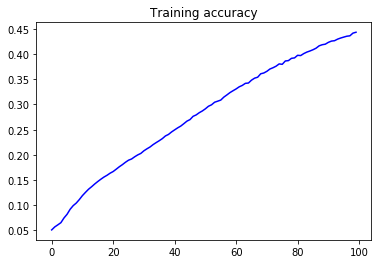

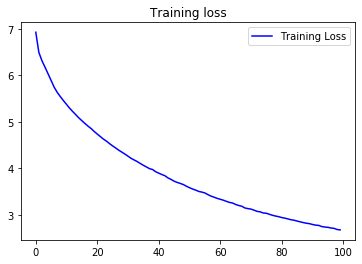

In [31]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [36]:
# Generate text
# Let's see the prediction of the model with this alternative opening sentence...
seed_text = "Longtemps je me suis couché tard, "
  
output_word = ""
while output_word != ".":
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=MAX_SEQUENCE_LEN-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    if output_word != ".":
        seed_text += " " + output_word
    else:
        seed_text += output_word
print(seed_text)

Longtemps je me suis couché tard,  qu’est ce que je n’avais pas eu là.
